In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [16]:
input_path = r'/Volumes/Behaviour/Tailored 3sec 2P Trials/Area Under the Curve/AUC Post'
output_path = r'/Volumes/Behaviour/Random Forest AUC_MAX/3sec Trials AUC'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
mice = ['2P05', '2P06', '2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

42

In [17]:
# AUC 3 SEC TRIALS
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue

    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[1][4:]+'_'+entries[2][:3]
        
    else:
        ses_name = entries[1][4:]+'_'+entries[2][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    # Try a SVM on single session
    category = np.array(cells['category'])
    binary = np.array(cells['binary'])
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, category, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, binary, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'3sec.csv'))
    
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'3sec.csv'))
    
cols = ['session', 'classification', 'accuracy']
rfc_accuracy = pd.DataFrame(accuracies, columns=cols)
rfc_accuracy.to_csv(os.path.join(output_path, 'rfc_accuracies_3sec.csv'))

processing:  auc_post2P05_Ses03.csv
2P05_Ses03
Accuracy modality: 0.125
Accuracy category: 0.375
Accuracy binary: 0.5
processing:  auc_post2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.125
Accuracy category: 0.625
Accuracy binary: 0.875
processing:  auc_post2P05_Ses06.csv
2P05_Ses06
Accuracy modality: 0.0
Accuracy category: 0.75
Accuracy binary: 0.875
processing:  auc_post2P05_Ses07.csv
2P05_Ses07
Accuracy modality: 0.0
Accuracy category: 0.14285714285714285
Accuracy binary: 0.8571428571428571
processing:  auc_post2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 0.0
Accuracy category: 0.5714285714285714
Accuracy binary: 0.42857142857142855
processing:  auc_post2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 0.14285714285714285
Accuracy category: 0.5714285714285714
Accuracy binary: 0.7142857142857143
processing:  auc_post2P06_Ses04.csv
2P06_Ses04
Accuracy modality: 0.25
Accuracy category: 0.625
Accuracy binary: 0.5
processing:  auc_post2P06_Ses05.csv
2P06_Ses05
Accuracy modality: 0.125
Accura

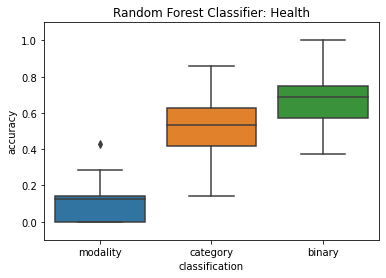

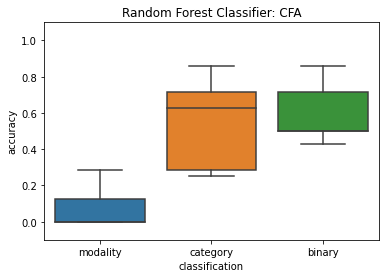

In [18]:
import seaborn as sns

health = rfc_accuracy[rfc_accuracy['session'].str.contains('Ses')]
cfa = rfc_accuracy[rfc_accuracy['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier: Health')
plt.ylim([-0.1,1.1])
plt.savefig(os.path.join(output_path, 'rfc_health_auc_3sec.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier: CFA')
plt.ylim([-0.1,1.1])
plt.savefig(os.path.join(output_path, 'rfc_cfa_auc_3sec.png'),bbox_inches='tight')
plt.show()

In [21]:
input_path = r'/Volumes/Behaviour/Tailored 90sec 2P Trials/Area Under the Curve/AUC Post'
output_path = r'/Volumes/Behaviour/Random Forest AUC_MAX/90sec Trials AUC'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
mice = ['2P05', '2P06', '2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

42

In [27]:
# AUC 90 SEC TRIALS
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue

    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[2]+'_'+entries[3][:3]
        
    else:
        ses_name = entries[2]+'_'+entries[3][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    # Try a SVM on single session
    category = np.array(cells['category'])
    binary = np.array(cells['binary'])
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, category, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, binary, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'90sec.csv'))
    
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'90sec.csv'))
    
cols = ['session', 'classification', 'accuracy']
rfc_accuracy = pd.DataFrame(accuracies, columns=cols)
rfc_accuracy.to_csv(os.path.join(output_path, 'rfc_accuracies_90sec.csv'))

processing:  auc_post_2P05_Ses03.csv
2P05_Ses03
Accuracy modality: 0.2857142857142857
Accuracy category: 0.2857142857142857
Accuracy binary: 0.42857142857142855
processing:  auc_post_2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.0
Accuracy category: 0.42857142857142855
Accuracy binary: 0.5714285714285714
processing:  auc_post_2P05_Ses06.csv
2P05_Ses06
Accuracy modality: 0.0
Accuracy category: 0.2857142857142857
Accuracy binary: 0.5714285714285714
processing:  auc_post_2P05_Ses07.csv
2P05_Ses07
Accuracy modality: 0.14285714285714285
Accuracy category: 0.42857142857142855
Accuracy binary: 0.7142857142857143
processing:  auc_post_2P06_Ses01.csv
2P06_Ses01
Accuracy modality: 0.0
Accuracy category: 0.14285714285714285
Accuracy binary: 0.42857142857142855
processing:  auc_post_2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 0.2857142857142857
Accuracy category: 0.14285714285714285
Accuracy binary: 0.42857142857142855
processing:  auc_post_2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 0.28571428

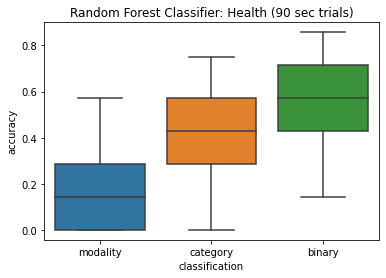

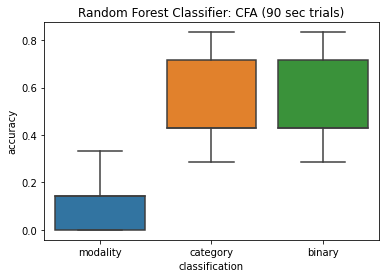

In [28]:
import seaborn as sns

health = rfc_accuracy[rfc_accuracy['session'].str.contains('Ses')]
cfa = rfc_accuracy[rfc_accuracy['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier: Health (90 sec trials)')
#plt.ylim([-0.1,1.1])
plt.savefig(os.path.join(output_path, 'rfc_health_auc_90sec.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier: CFA (90 sec trials)')
#plt.ylim([-0.1,1.1])
plt.savefig(os.path.join(output_path, 'rfc_cfa_auc_90sec.png'),bbox_inches='tight')
plt.show()

In [29]:
input_path = r'/Volumes/Behaviour/Tailored 90sec 2P Trials/Maxima'
output_path = r'/Volumes/Behaviour/Random Forest AUC_MAX/90sec Trials MAX'
stimuli = ['warm', 'hot', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']
mice = ['2P05', '2P06', '2P07', '2P08', '2P09', '2P10', '2P11']
sessions = [session for session in os.listdir(input_path) if session.endswith('.csv')]
len(sessions)

42

In [33]:
# MAXIMA 3 SEC TRIALS
session_names = []
accuracies = []

for session in sessions:
    if session.startswith('._'): # circumventing issues with invisible files on external drives
        continue

    print('processing: ', session)
    entries = session.split('_')
    
    if session.endswith('CFA.csv'): 
        ses_name = entries[3]+'_'+entries[4][:3]
        
    else:
        ses_name = entries[3]+'_'+entries[4][:5]
            
    print(ses_name)
    session_names.append(ses_name)
    
    cells = pd.read_csv(os.path.join(input_path,session), index_col=0)
    cell_ids = list(cells.columns)
    
    trials = cells['identifier'].unique()
    
    # Add 'modality' column
    conditions = [
    cells['identifier'].str.contains('hot'), cells['identifier'].str.contains('warm'), cells['identifier'].str.contains('opto'),
    cells['identifier'].str.contains('off-target'), cells['identifier'].str.contains('von frey'), cells['identifier'].str.contains('pin-prick'),
    cells['identifier'].str.contains('approach'), cells['identifier'].str.contains('no stim')
    ]

    values = ['hot', 'warm', 'opto', 'off-target', 'von frey', 'pin-prick', 'approach', 'no stim']

    cells['modality'] = np.select(conditions, values)
    
    # Add 'category' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick'),
    (cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['noxious', 'innocuous', 'control']

    cells['category'] = np.select(conditions, values)
    
    # Add 'binary' column
    conditions = [
    (cells['modality'] == 'hot')|(cells['modality'] == 'opto')|(cells['modality'] == 'pin-prick')|(cells['modality'] == 'warm')|(cells['modality'] == 'von frey'),
    (cells['modality'] == 'off-target')|(cells['modality'] == 'approach')|(cells['modality'] == 'no stim')
    ]

    values = ['stimulation', 'control']

    cells['binary'] = np.select(conditions, values)
    
    # Try a SVM on single session
    category = np.array(cells['category'])
    binary = np.array(cells['binary'])
    modality = np.array(cells['modality'])
    data = cells.drop(['identifier','modality', 'category','binary'], axis=1)
    data = np.array(data)
    
    # MODALITY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, modality, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy modality:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'modality', metrics.accuracy_score(y_test, y_pred)])
    
    # CATEGORY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, category, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy category:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'category', metrics.accuracy_score(y_test, y_pred)])   

    # BINARY
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(data, binary, test_size=0.3,random_state=109) # 70% training and 30% test

    clf = RandomForestClassifier(n_estimators=100)

    #Train the model using the training sets
    clf.fit(X_train, y_train)

    #Predict the response for test dataset
    y_pred = clf.predict(X_test)

    print("Accuracy binary:",metrics.accuracy_score(y_test, y_pred))
    accuracies.append([ses_name, 'binary', metrics.accuracy_score(y_test, y_pred)])
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'90sec.csv'))
    
    
    feature_imp = pd.Series(clf.feature_importances_,index=cell_ids[:-1]).sort_values(ascending=False)
    feature_imp = pd.DataFrame(feature_imp, columns = ['feat_imp'])
    feature_imp.to_csv(os.path.join(output_path, 'feat_imp_'+ses_name+'90sec.csv'))
    
cols = ['session', 'classification', 'accuracy']
rfc_accuracy = pd.DataFrame(accuracies, columns=cols)
rfc_accuracy.to_csv(os.path.join(output_path, 'rfc_accuracies_90sec_maxis.csv'))

processing:  post_maxima_90sec_2P06_Ses01.csv
2P06_Ses01
Accuracy modality: 0.0
Accuracy category: 0.0
Accuracy binary: 0.42857142857142855
processing:  post_maxima_90sec_2P06_Ses02.csv
2P06_Ses02
Accuracy modality: 0.0
Accuracy category: 0.42857142857142855
Accuracy binary: 0.5714285714285714
processing:  post_maxima_90sec_2P06_Ses03.csv
2P06_Ses03
Accuracy modality: 0.2857142857142857
Accuracy category: 0.42857142857142855
Accuracy binary: 0.5714285714285714
processing:  post_maxima_90sec_2P05_Ses04.csv
2P05_Ses04
Accuracy modality: 0.0
Accuracy category: 0.42857142857142855
Accuracy binary: 0.5714285714285714
processing:  post_maxima_90sec_2P06_Ses04.csv
2P06_Ses04
Accuracy modality: 0.375
Accuracy category: 0.75
Accuracy binary: 0.5
processing:  post_maxima_90sec_2P06_Ses05.csv
2P06_Ses05
Accuracy modality: 0.2857142857142857
Accuracy category: 0.42857142857142855
Accuracy binary: 0.7142857142857143
processing:  post_maxima_90sec_2P05_Ses06.csv
2P05_Ses06
Accuracy modality: 0.0
Acc

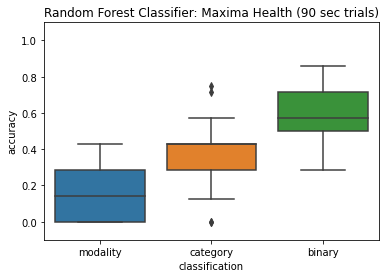

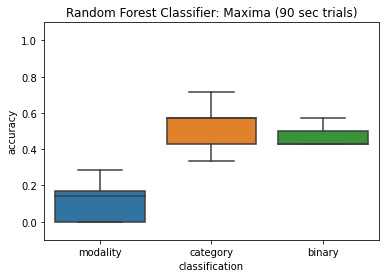

In [35]:
health = rfc_accuracy[rfc_accuracy['session'].str.contains('Ses')]
cfa = rfc_accuracy[rfc_accuracy['session'].str.contains('CFA')]

sns.boxplot(data=health, x='classification', y='accuracy')
plt.title('Random Forest Classifier: Maxima Health (90 sec trials)')
plt.ylim([-0.1,1.1])
plt.savefig(os.path.join(output_path, 'rfc_health_max_90sec.png'),bbox_inches='tight')
plt.show()

sns.boxplot(data=cfa, x='classification', y='accuracy')
plt.title('Random Forest Classifier: Maxima (90 sec trials)')
plt.ylim([-0.1,1.1])
plt.savefig(os.path.join(output_path, 'rfc_cfa_max_90sec.png'),bbox_inches='tight')
plt.show()

In [32]:
rfc_accuracy

,session,classification,accuracy
0,90sec_2P06,modality,0.000000
1,90sec_2P06,category,0.000000
2,90sec_2P06,binary,0.428571
3,90sec_2P06,modality,0.000000
4,90sec_2P06,category,0.142857
...,...,...,...
121,90sec_2P1,category,0.285714
122,90sec_2P1,binary,0.428571
123,90sec_2P05,modality,0.000000
124,90sec_2P05,category,0.142857
